# Chicago Divvy Bike Ride-Sharing Analysis

![alt text](images/divvy.jpg)
![alt_text](images/divvy_map.jpg)

### Introduction
This notebook is based on the [Divvy Ride-Sharing Kaggle dataset and competition](https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data) for Divvy bike rides in Chicago, IL. It's a re-creation of a program I created about a year ago that was lost when a hard drive died and I've since learned my lesson so this is going straight to git. Some of the features of the previous program will be implemented but I really want to try to divide the notebooks more atomically so that each serves a pretty specific purpose and doesn't have too large of scope. 

### Goals of the Notebook
 * Conditionally split dataset
 * Determine which stations are busiest/where they usually lead to
 * Show distributions of the data, branch out with Seaborn library
 * Map rides using Basemap--really improve my skills with that
 * Perform machine learning and create models using Scikit-Learn
 

### Importing 
Just a typical data science library stack for the EDA notebook.

In [1]:
import os
import math
import random
import subprocess

import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

from tqdm import tqdm

pd.set_option('mode.chained_assignment', None)

### CSV File Exploration and Importing

The first thing we'll do is peer into the csv files provided by Kaggle to see what kind of data we're looking at. Since the data is incredibly large (don't have a week for operating on 9 million divvy bike rides), for this stage of the analysis we'll just take a random sampling from the data.

To randomize the import I'm just going to retrieve every 1/n lines from the file. 

**Updated 8/20/19:** Changing import methods based on [this kaggle kernel](https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows)

In [2]:
%%time

filename = "data/data.csv"

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0]) + 1

n_rows = file_len(filename)
print('Data file contains {} rows'.format(n_rows))

Data file contains 9495237 rows
CPU times: user 2.23 ms, sys: 8.11 ms, total: 10.3 ms
Wall time: 1.75 s


In [3]:
df_tmp = pd.read_csv(filename, nrows=5)
df_tmp.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


In [4]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 23 columns):
trip_id              5 non-null int64
year                 5 non-null int64
month                5 non-null int64
week                 5 non-null int64
day                  5 non-null int64
hour                 5 non-null int64
usertype             5 non-null object
gender               5 non-null object
starttime            5 non-null object
stoptime             5 non-null object
tripduration         5 non-null float64
temperature          5 non-null float64
events               5 non-null object
from_station_id      5 non-null int64
from_station_name    5 non-null object
latitude_start       5 non-null float64
longitude_start      5 non-null float64
dpcapacity_start     5 non-null float64
to_station_id        5 non-null int64
to_station_name      5 non-null object
latitude_end         5 non-null float64
longitude_end        5 non-null float64
dpcapacity_end       5 non-null float64
dt

In [5]:
traintypes = {
    'trip_id': 'int32',
    'year': 'uint16',
    'month': 'uint8',
    'week': 'uint8',
    'day': 'uint8',
    'hour': 'uint8',
    'usertype': 'str',
    'gender': 'str',
    'starttime': 'str',
    'stoptime': 'str',
    'tripduration': 'float32',
    'temperature': 'float32',
    'events': 'str',
    'from_station_id': 'int32',
    'from_station_name': 'str',
    'latitude_start': 'float32',
    'longitude_start': 'float32',
    'dpcapacity_start': 'float32',
    'to_station_id': 'int32',
    'to_station_name': 'str',
    'latitude_end': 'float32',
    'longitude_end': 'float32',
    'dpcapacity_end': 'float32'
}
cols = list(traintypes.keys())

In [6]:
chunksize = 1_000_000

In [7]:
%%time
df_list = []

for df_chunk in tqdm(
    pd.read_csv(
        filename, 
        usecols=cols, 
        dtype=traintypes, 
        chunksize=chunksize
    )
):
    df_chunk['starttime'] = df_chunk['starttime'].str.slice(0, 16)
    df_chunk['starttime'] = pd.to_datetime(df_chunk['starttime'], utc=True, format='%Y-%m-%d %H:%M')
    
    df_list.append(df_chunk)

10it [00:34,  3.46s/it]

CPU times: user 31.8 s, sys: 2.57 s, total: 34.4 s
Wall time: 34.6 s


In [8]:
data_df = pd.concat(df_list[0:1])

del df_list

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 23 columns):
trip_id              1000000 non-null int32
year                 1000000 non-null uint16
month                1000000 non-null uint8
week                 1000000 non-null uint8
day                  1000000 non-null uint8
hour                 1000000 non-null uint8
usertype             1000000 non-null object
gender               1000000 non-null object
starttime            1000000 non-null datetime64[ns, UTC]
stoptime             1000000 non-null object
tripduration         1000000 non-null float32
temperature          1000000 non-null float32
events               1000000 non-null object
from_station_id      1000000 non-null int32
from_station_name    1000000 non-null object
latitude_start       1000000 non-null float32
longitude_start      1000000 non-null float32
dpcapacity_start     1000000 non-null float32
to_station_id        1000000 non-null int32
to_station_name      1

**Thoughts:** There are a few really interesting features contained within the dataset that I'll want to explore moving foward in this notebook. I'll break the features down sort of categorically here.

**Geographical:**
 * from_station_id
 * from_station_name
 * latitude_start
 * longitude_start
 * to_station_id
 * to_station_name
 * latitude_end
 * longitude_end
 
**Weather:**
 * temperature
 * events
 
**Datetime:**
 * year
 * month
 * week
 * day
 * hour
 * starttime
 * stoptime
 * tripduration
 
**User-Specific:**
 * usertype
 * gender

### Feature Engineering

There are a couple of columns that we can build from our current set of features.

In [9]:
def haversine(row):
    lon1 = row['longitude_start']
    lat1 = row['latitude_start']
    lon2 = row['longitude_end']
    lat2 = row['latitude_end']
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km

data_df['displacement'] = data_df.apply(lambda row: haversine(row), axis=1)
data_df['rate'] = data_df['displacement'].div(data_df['tripduration']).multiply(60)

## General Data Distribution

In [10]:
num_df = data_df.drop(
    [
        'trip_id', 
        'usertype',
        'events',
        'from_station_id',
        'from_station_name',
        'to_station_id',
        'to_station_name',
        'dpcapacity_start',
        'dpcapacity_end'
    ], axis=1
)

### Thoughts:
* Divvy popularity grew over the course of data collection
* People like riding bikes in the summer
* People take bikes to and from work (9AM and 5PM)
* People don't like to ride bikes for more than about 10 minutes
* People like riding bikes when it's about 70 degrees out
* People seem to ride north more than south
* People seem to ride east more than west

### Weather Analysis

**Vanilla Distributions**

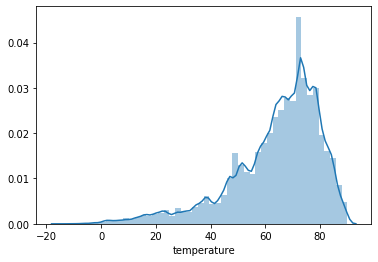

In [11]:
sns.distplot(
    data_df.temperature
)

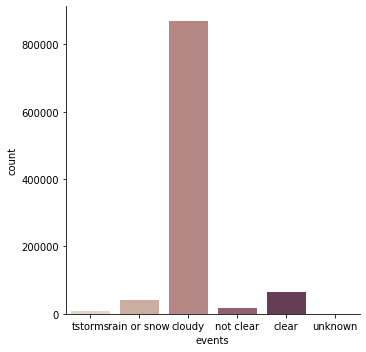

In [12]:
sns.catplot(
    x='events',
    data=data_df,
    kind='count',
    palette='ch:.25'
)

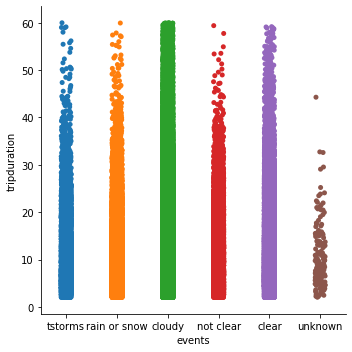

In [13]:
sns.catplot(
    x='events',
    y='tripduration',
    data=data_df
)

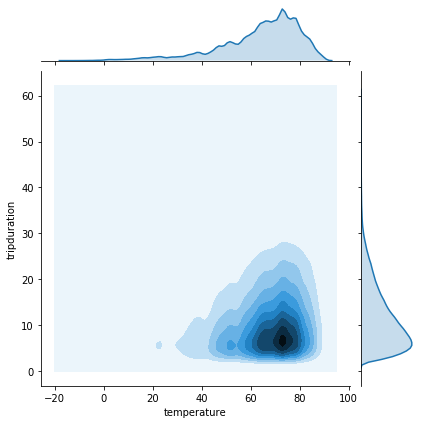

In [14]:
sns.jointplot(
    data_df['temperature'], 
    data_df['tripduration'],
    kind='kde'
)

**Conditional Splitting**

In [15]:
hot_rides  = data_df[data_df['temperature'] > 80]
cold_rides = data_df[data_df['temperature'] < 10]

80.099998    23227
82.000000    15842
84.000000    15469
81.000000    14880
82.900002    14158
84.900002    12007
86.000000    11402
87.099998     4603
88.000000     4438
82.400002     3637
89.099998     3489
84.199997     2922
80.599998     2836
90.000000     2324
87.800003     2172
Name: temperature, dtype: int64


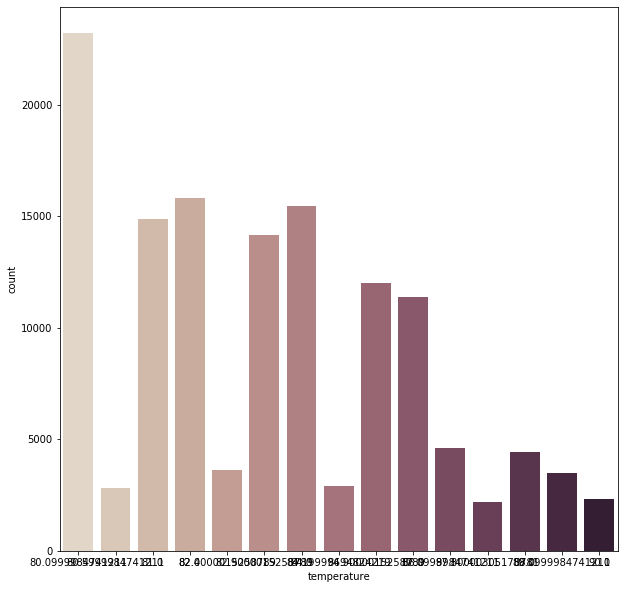

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
sns.catplot(
    x='temperature',
    data=hot_rides,
    kind='count',
    palette='ch:.25',
    ax=ax
)
print(hot_rides['temperature'].value_counts())
plt.close(2)
plt.show()

 9.0     1107
 1.9      946
 5.0      775
 7.0      749
 3.0      721
 6.1      686
 3.9      645
 8.1      609
 1.0      546
-0.0      379
-2.9      302
-2.0      263
-6.0      174
 6.8      149
-0.9      117
 8.6       94
-5.1       81
-8.0       74
 3.2       60
-4.0       49
-9.9       26
-11.0      25
-2.2       22
 1.4       10
-7.1        5
-15.0       1
Name: temperature, dtype: int64


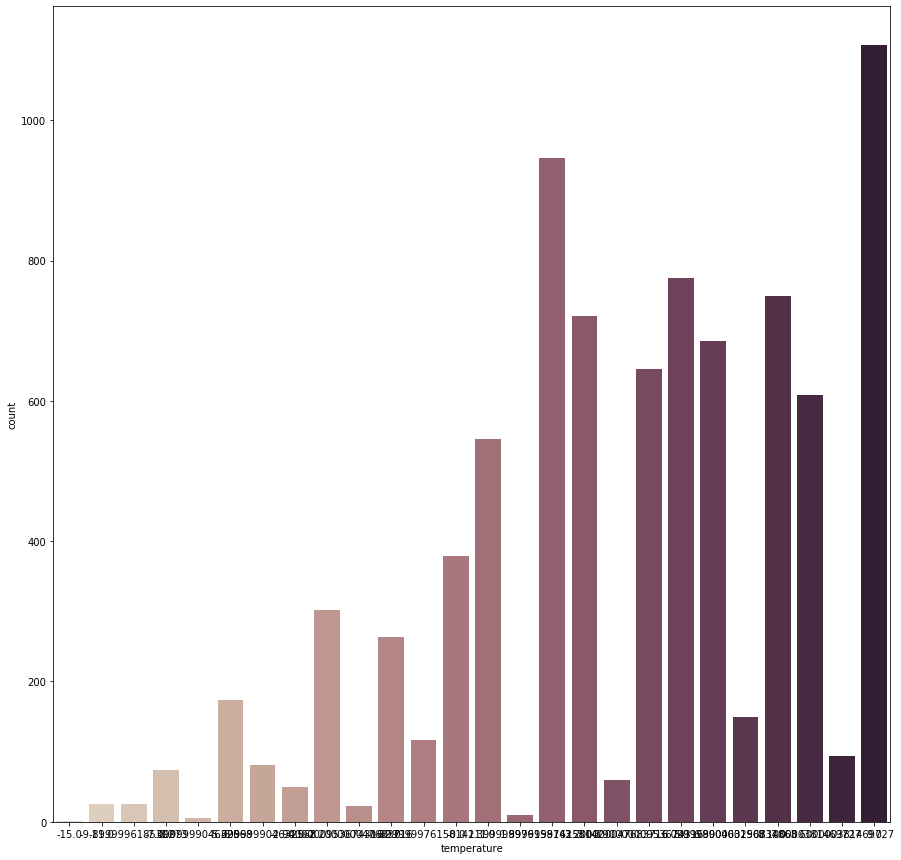

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
sns.catplot(
    x='temperature',
    data=cold_rides,
    kind='count',
    palette='ch:.25',
    ax=ax
)
print(cold_rides['temperature'].value_counts())
plt.close(2)
plt.show()

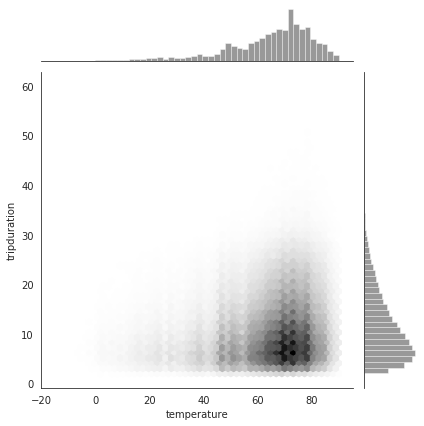

In [18]:
with sns.axes_style("white"):
    sns.jointplot(
        x=data_df['temperature'], 
        y=data_df['tripduration'], 
        kind="hex", 
        color="k",
    )

### Distance Analysis

**Vanilla Distributions**

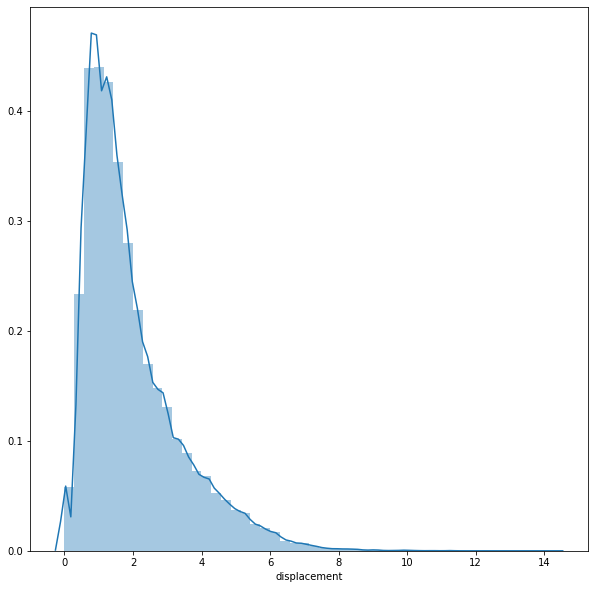

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

sns.distplot(data_df.displacement, ax=ax)

plt.show()

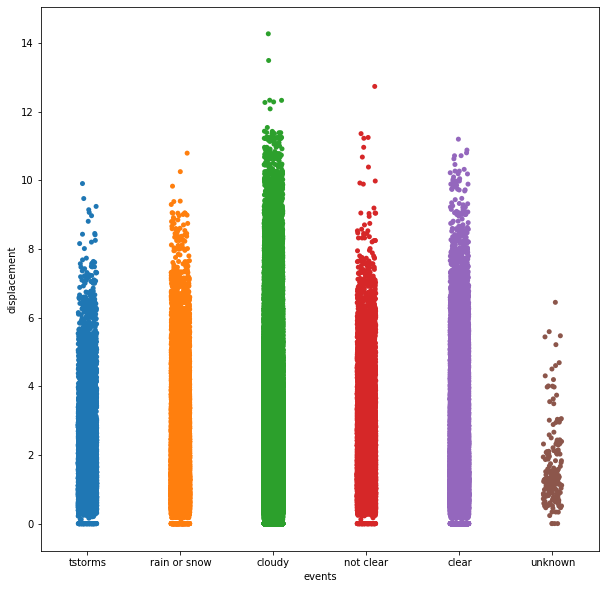

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

sns.catplot(
    x='events',
    y='displacement',
    data=data_df,
    ax=ax
)

plt.close(2)
plt.show()